In [1]:
from pyonset import Onset, BootstrapWindow, OnsetStatsArray

In [2]:
# First we have the data in a pandas dataframe, indexed by time and preferably the index knows the frequency
# We need to tell the software the particle species and all of the channel energy boundaries
# The software has to differentiate between custom data and default data when running processes (self.custom_data)
import os
import numpy as np
import pandas as pd

In [3]:
# The path to the data archive
example_data_path = "/home/data/path"

# The name of the file to read in
filename = "intensity_data.csv"

# Reading the file to a dataframe
try:
    df = pd.read_csv(f"{example_data_path}{os.sep}{filename}", index_col="Time")
except FileNotFoundError:
    tmp_data_len = 1440
    df = pd.DataFrame(data={"HET1" : np.random.poisson(lam=(np.tanh(np.linspace(start=-15, stop=5, num=tmp_data_len))+2)*1e2-99, size=tmp_data_len)}, 
                      index=pd.date_range("2024-11-01 00:00", periods=tmp_data_len, freq="1 min"))

# The index of the dataframe needs to be datetime, and the frequency of it should be known. If not, the software
# will try to infer it later when running the onset_statistics_per_channel() -method, if the hybrid method is 
# to be applied.
df.index = pd.to_datetime(df.index)
df.index.freq = "1 min"

# Displays the dataframe (optional)
display(df)

,HET1
2024-11-01 00:00:00,2
2024-11-01 00:01:00,0
2024-11-01 00:02:00,1
2024-11-01 00:03:00,3
2024-11-01 00:04:00,1
...,...
2024-11-01 23:55:00,199
2024-11-01 23:56:00,192
2024-11-01 23:57:00,190
2024-11-01 23:58:00,201


<Axes: >

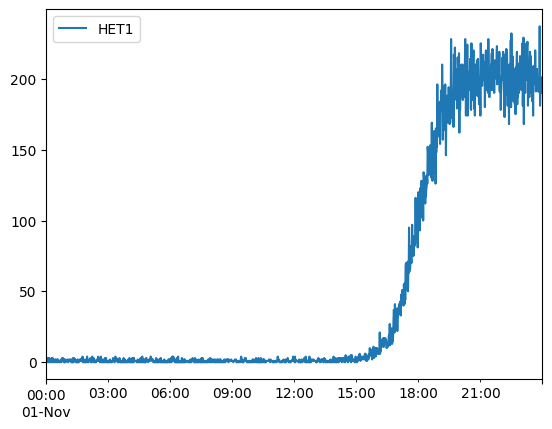

In [4]:
df.plot()

### Initializing the object:

In [5]:
# Spacecraft-related identifiers
spacecraft_name = "Solar Orbiter"
sensor_name = "HET"
particle_species = "proton"

# Data level required when employing SEPpy data-loading capabilities. 
# 'l2' is the standard level 2 data product, but 'll' = low latency is also possible, though
# not recommended for scientific analysis.
# If using custom data, data_level is irrelevant.
data_level = "l2"

# The start and end dates tell the SEPpy data-loaders from which dates to download the data.
# If employing custom data, these parameters are irrelevant.
start_date = "2024-11-01"
end_date = "2024-11-01"

# The keyword 'data' when given to the object initializer tells the software to NOT use SEPpy
# data loading, and instead use the specified pandas DataFrame as the data to work on.
data = df

# Object intialization
protons = Onset(spacecraft=spacecraft_name, sensor=sensor_name, species=particle_species, 
                  data_level=data_level, data_path=example_data_path,
                 start_date=start_date, end_date=end_date,
                 data=data)

Utilizing user-input data. Some SEPpy functionality may not work as intended.


The method `get_custom_channel_energies()` returns the custom data energy channel low and high boundaries in eVs.
If the user has not explicitly set the channel energies, the method prints the AttributeError raised by python, and guides the user on how to set the energy channel boundaries.

In [6]:
protons.get_custom_channel_energies()

'Onset' object has no attribute 'channel_energy_lows'
This is caused by user-defined custom data, that has no defined energy channel boundary values.
Define energy channel boundaries with 'set_custom_channel_energies()'!


In [7]:
# In case of custom data, the software needs to be explicitly told what are the boundaries 
# of the energy channels.

# The lower boundary values of the energy channels in order from lowest channel to the highest
channel_lows = [7]

# The high boundaries of the energy channels in order
channel_highs = [7.5]

# The unit of energy. Choose from 'eV', 'keV' or 'MeV'.
unit = "MeV"

protons.set_custom_channel_energies(low_bounds=channel_lows, high_bounds=channel_highs, unit=unit)

The quick-look onset time can be displayed with `cusum_onset()` -method, which needs to know at least the channel, plotting range, pre-event background, time-averaging information, length of the cusum window, and plotting switch.

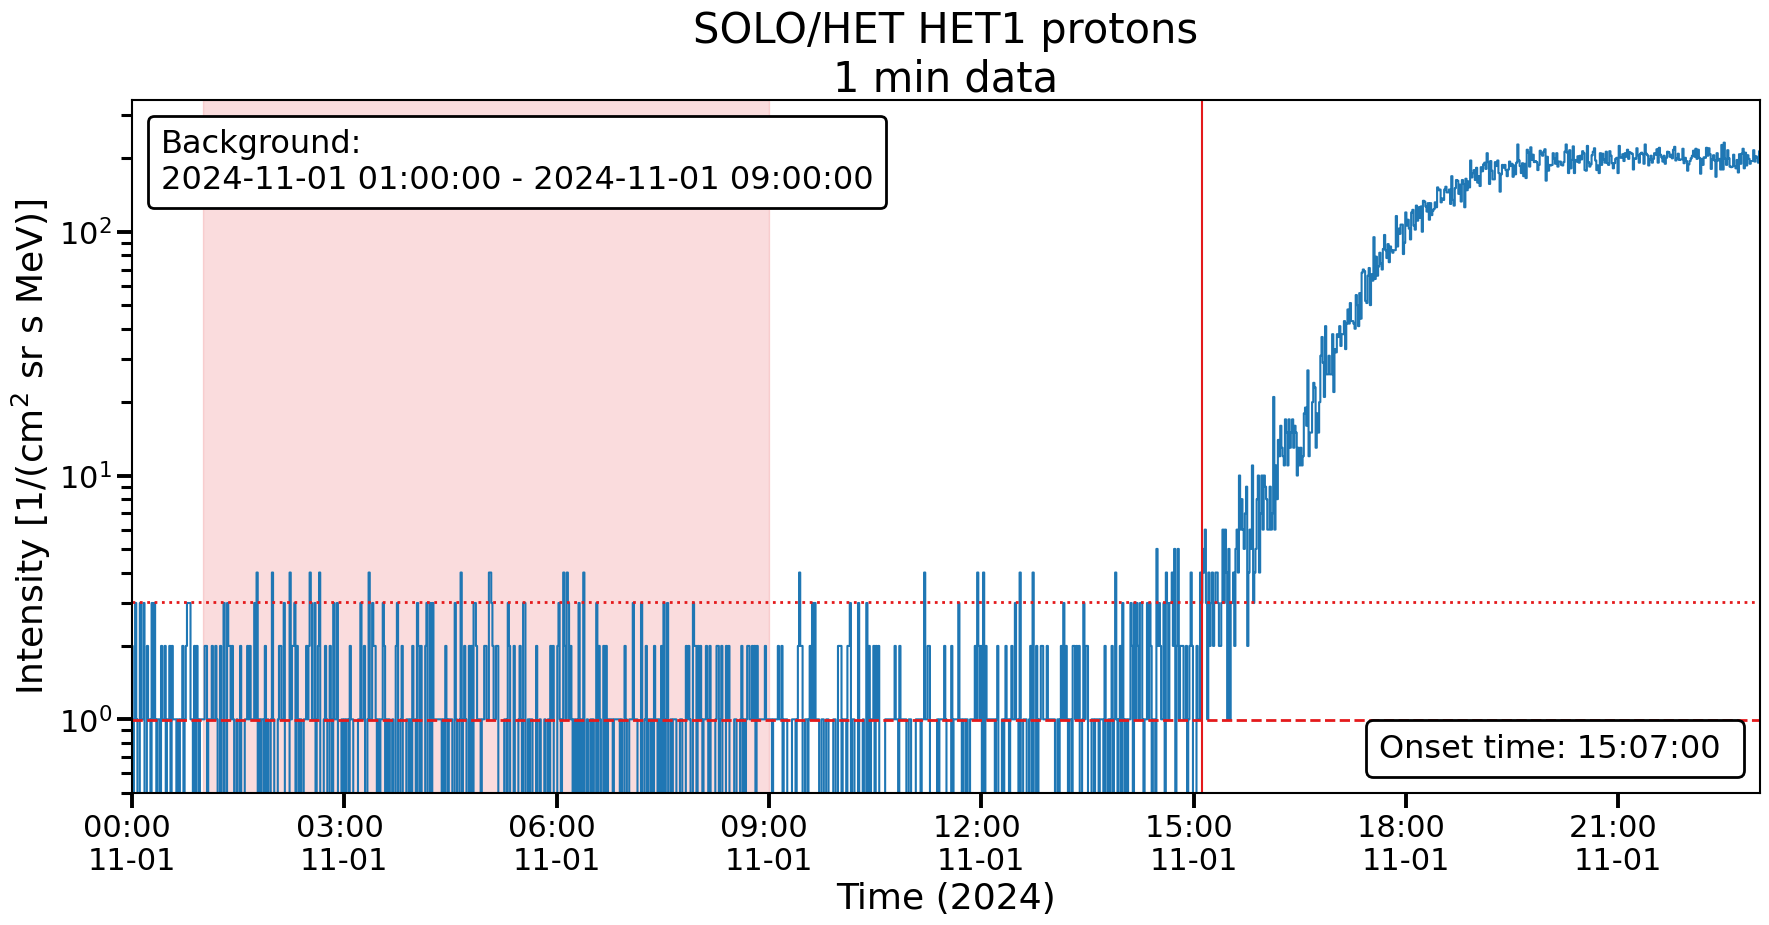

In [8]:
# The channel on which to run cusum_onset() on. Integer value if SEPpy-downloaded data, string/int in the 
# case of custom data. 
channel = "HET1"

# A tuple of 2 strings, indicating the start and end of the plot.
plot_range = ["2024-11-01 00:00", "2024-11-01 23:00"]

# A special BootstrapWindow object acts as the pre-event background window. It requires the
# start and end (pandas-compatible datetime strings) of the background. It also takes as an
# input the amount of bootstrap samples (integer, recommended n=1000) to take when applying
# the hybrid method.
background = BootstrapWindow(start="2024-11-01 01:00", end="2024-11-01 09:00", bootstraps=1000)

# The parameter 'resample' controls if to time-average the data, and if, then how. Leave to None to not
# apply any time-averaging. Use a pandas-compatible timedelta str, e.g., '30 s' or '5 min' to average the
# data to said time resolution.
resample = None #"10 min"

# The amount of time, in minutes, that the Poisson-CUSUM method requires for the intensity to remain at
# a threshold-exceeding value before identifying the onset time. Usually best to keep ar 30 or 60 minutes.
# This parameter is always an integer.
cusum_minutes = 60

# A boolean switch to produce a plot of the onset time. If plot is produced, plot_range controls the 
# left and right boundaries of the plot.
plot = True


# The cusum_onset() -method returns onset_stats and flux_series.
# onset_stats is a list of onset statistics, it contains in order the mean of the background, the mean
# of the background + n * standard deviation of the background, the value of the control parameter k 
# (related to the Poisson-CUSUM function), the z-standardized intensity values of the data, and 
# finally the onset time as a timestamp.
# flux_series is a pandas Series object containing the data from which the onset was found.
onset_stats, flux_series = protons.cusum_onset(channels=channel, background_range=background, 
                                                 xlim=plot_range, resample=resample, 
                                                 cusum_minutes=cusum_minutes, plot=plot)

The `onset_statistics_per_channel()` -method runs the hybrid method, employing Poisson-CUSUM coupled with statistical bootstrapping and varying data integration time, to find the most probable onset time and the uncertainty related to it for each given energy channel.

In [9]:
# Random seed for the random process that is applied in the bootstrapping of data samples.
rng = 101010101

# The percentage of data points for each bootstrap sample to consider in the calculation of 
# background parameters. Recommended to keep between 0.5 and 0.9.
sample_size = 0.75

# Don't apply time-averaging too far, in order to conserve at least 100 data points in the background
limit_averaging = "4 min"

# A boolean switch to print out mid-step information during the hybrid method processing data
print_output = True

# Runs the hybrid method on all energy channels. In case of custom data, the names of 
# the channels must be explicitly stated
all_channels = list(protons.data.columns)

uncertainty_stats_by_channel = protons.onset_statistics_per_channel(channels=all_channels, 
                                                                    background=background, 
                                                                    cusum_minutes=cusum_minutes,
                                                                    sample_size=sample_size, 
                                                                    viewing=protons.viewing, 
                                                                    limit_averaging=limit_averaging,
                                                                    random_seed=rng,
                                                                    print_output=print_output)


Your chosen background is 480 minutes long. To preserve the minimum of 100 data points to choose from,
it is recommended that you either limit averaging up to 4 minutes or enlarge the background window.
Channel HET1:
~68 % uncertainty for the self time with native data resolution: 0 days 00:01:00
Averaging up to 1 minutes


Calling the `onset_statistics` -attribute of the Onset object after the method `onset_statistics_per_channel()` has been ran, displays a dictionary that contains the mode, median, ~68 % and ~95 % cofidence intervals for the onset times in the considered channels.

In [10]:
protons.onset_statistics

{'HET1': [Timestamp('2024-11-01 15:07:00'),
  Timestamp('2024-11-01 15:07:00'),
  Timestamp('2024-11-01 15:06:30'),
  Timestamp('2024-11-01 15:07:30'),
  Timestamp('2024-11-01 15:06:30'),
  Timestamp('2024-11-01 15:24:00')]}

### VDA
The `VDA()` -method either performs velocity dispersion analysis on onset times in the `onset_statistics` dictionary of the object, or on timestamps given as a list/array to the parameter `onset_times`. 

In [11]:
# A selection can either be a boolean list that selects the onset times to consider for the fit, or a Python
# slice object to select a range of channels.
selection = [True]
selection = slice(0,1)


# Running the VDA()-method returns a dictionary of the results of the vda, and everything 
# that is required to replicate the plot
vda_result = protons.VDA(selection=selection)

AttributeError: 'Onset' object has no attribute 'current_energies'

In [12]:
vda_result

{'inverse_beta': masked_array(data=[8.093076480370511],
              mask=[False],
        fill_value=1e+20),
 'x_errors': masked_array(data=[0.002407581144844073],
              mask=[False],
        fill_value=1e+20),
 'onset_times': masked_array(data=[Timestamp('2024-11-01 15:16:00')],
              mask=[False],
        fill_value='?',
             dtype=object),
 'y_errors': masked_array(
   data=[[Timedelta('0 days 00:00:30')],
         [Timedelta('0 days 00:02:00')]],
   mask=[[False],
         [False]],
   fill_value='?',
   dtype=object),
 'path_length': 1.0,
 't_inj': datetime.datetime(2024, 11, 1, 15, 16),
 'path_length_uncertainty': nan,
 't_inj_uncertainty': nan,
 'residual_variance': 1.0998737301264279,
 'stopreason': ['NP < 1 or NP > N'],
 'fig': <Figure size 1152x648 with 1 Axes>,
 'axes': <Axes: title={'center': 'VDA, SOLAR ORBITER / HET protons, 2024-11-01'}, xlabel='1/$\\beta$', ylabel='Time (HH:MM:SS)'>}

VDA() can also be applied using a list of timestamps `onset_times`, accompanied by a list of errors `yerrs`.

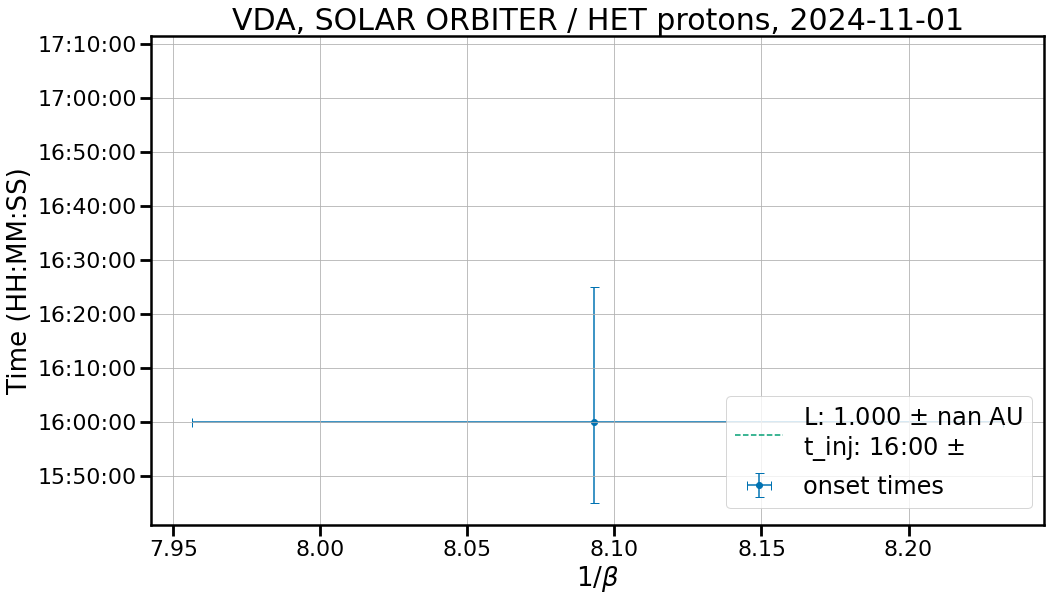

In [13]:
# A list of timestamps. Onset times must appear in the same order as the defined channels do, from lower energy to higher.
onset_times = [pd.Timestamp("2024-11-01 16:00:00")]

# Y-errors is a list of 2 lists: negative errors in the first and positive in the second list.
yerrs = [[pd.Timedelta(minutes=15)], [pd.Timedelta(minutes=25)]]

# VDA() accepts onset_times and yerrs as optional input parameters
new_vda_result = protons.VDA(onset_times=onset_times, yerrs=yerrs)

In [14]:
new_vda_result

{'inverse_beta': masked_array(data=[8.093076480370511],
              mask=[False],
        fill_value=1e+20),
 'x_errors': masked_array(data=[0.002407581144844073],
              mask=[False],
        fill_value=1e+20),
 'onset_times': masked_array(data=[Timestamp('2024-11-01 16:00:00')],
              mask=[False],
        fill_value='?',
             dtype=object),
 'y_errors': masked_array(
   data=[[Timedelta('0 days 00:15:00')],
         [Timedelta('0 days 00:25:00')]],
   mask=[[False],
         [False]],
   fill_value='?',
   dtype=object),
 'path_length': 1.0,
 't_inj': datetime.datetime(2024, 11, 1, 16, 0),
 'path_length_uncertainty': nan,
 't_inj_uncertainty': nan,
 'residual_variance': 1.0998737301264279,
 'stopreason': ['NP < 1 or NP > N'],
 'fig': <Figure size 1152x648 with 1 Axes>,
 'axes': <Axes: title={'center': 'VDA, SOLAR ORBITER / HET protons, 2024-11-01'}, xlabel='1/$\\beta$', ylabel='Time (HH:MM:SS)'>}